# Sentiment Analysis Visualizations for the Earnings Call Transcript
Used FinBERT for the sentiment analysis.

I ran this locally, no GPU.

Reference: [Financial Sentiment Analysis on Stock Market Headlines With FinBERT & HuggingFace](https://wandb.ai/ivangoncharov/FinBERT_Sentiment_Analysis_Project/reports/Financial-Sentiment-Analysis-on-Stock-Market-Headlines-With-FinBERT-Hugging-Face--VmlldzoxMDQ4NjM0)

## (1) Presentation Section

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt

/Users/muno/.pyenv/versions/3.8.18/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
FILE_PATH = 'csv/BNY-Q2-2023_presentation_sentiment_summary.csv'

In [25]:
pres_sentiment_df = pd.read_csv(FILE_PATH, converters={'Sentiment Scores': pd.eval, 'Sentiment Labels': pd.eval})

In [26]:
display(pres_sentiment_df.head())

,Speaker ID,Speaker Company,Speaker Name,Statement,Sentiment Scores,Sentiment Labels,Top Sentiment Label,Analysis Summary
0,-1,NaN,Operator,"Good morning, and welcome to the 2023 Second Q...","[[[0.3694128692150116], [0.012827406637370586]...","[neutral, neutral, neutral, neutral, neutral, ...",neutral,Overall sentiment is neutral. 0 sentences are ...
1,1,Head of Investor Relations,Marius Merz,"Thank you, operator, and good morning, everyon...","[[[0.2496730089187622], [0.015016406774520874]...","[neutral, neutral, neutral, neutral, neutral, ...",neutral,Overall sentiment is neutral. 0 sentences are ...
2,2,"President, CEO & Director",Robin Antony Vince,"Thanks, Marius, and thank you, everyone, for j...","[[[0.4186753034591675], [0.017740001901984215]...","[neutral, neutral, positive, neutral, positive...",positive,Overall sentiment is positive. 33 sentences ar...
3,0,Senior Executive VP & CFO,Dermot William McDonogh,"Thank you, Robin, and good morning, everyone. ...","[[[0.15950359404087067], [0.018644608557224274...","[neutral, neutral, neutral, positive, positive...",positive,Overall sentiment is positive. 56 sentences ar...


Descriptions for new columns related to the sentiment analysis:
- **sentiment scores**: prediction from finBERT. for each sentence in the Statement text, there is a list of 3 predictions (x,y,z) corresponding to the score for positive, negative, and neutral sentiments respectively

- **sentiment labels**: max score from x,y,z is stored. a sentiment label for each sentence

- **top sentiment label**: given all sentiment labels, we find the one with the highest frequency

- **analysis summary**: a text string with the top sentiment label, the number of sentences & percentage of sentences that are positive, negative, neutral. if there are any negative sentences, the direct quotes are pulled out also.

In [29]:
def plot_sentiment_labels(sentiment_labels, plot_label):
    # Count the occurrences of each sentiment label
    label_counts = {}
    for label in sentiment_labels:
        label_counts[label] = label_counts.get(label, 0) + 1

    # Plot the distribution of labels
    counts = label_counts['positive'], label_counts['negative'], label_counts['neutral']
    plt.bar('positive', counts[0], color='green') 
    plt.bar('negative', counts[1], color='red') 
    plt.bar('neutral', counts[2], color='blue') 

    for y,x in enumerate(counts):
        plt.annotate(str(x), xy=(y,x), va='bottom')

    plt.xlabel('Sentiment Labels')
    plt.ylabel('Number of Sentences')
    plt.title(f'Distribution of Sentiment Labels for {plot_label}')
    plt.show()


In [30]:
def plot_sentiment_scores(sentiment_scores, sentiment_labels, plot_label):

    sentiment_array = np.array(sentiment_scores) # len sentences x pos,neg,neutr x tensors
    positive, negative, neutral = sentiment_array[:,0,:], sentiment_array[:,1,:], sentiment_array[:,2,:]

    # Plot sentiment scores
    plt.figure(figsize=(10, 6))
    idx = range(1, len(sentiment_scores) + 1)  # Create index numbers (1-based)
    plt.scatter(idx, positive, label="Positive", marker='o', color='green') 
    plt.scatter(idx, negative, label="Negative", marker='s', color='red') 
    plt.scatter(idx, neutral, label="Neutral", marker='^', color='blue')

    plt.xlabel('Sentence Index')
    plt.ylabel('Sentiment Score')
    plt.title(f'Scatter Plot of Sentiment Scores for {plot_label}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [31]:
head_ir_labels, head_ir_scores = pres_sentiment_df.loc[1, 'Sentiment Labels'], pres_sentiment_df.loc[1, 'Sentiment Scores']
ceo_labels, ceo_scores = pres_sentiment_df.loc[2, 'Sentiment Labels'], pres_sentiment_df.loc[2, 'Sentiment Scores']
cfo_labels, cfo_scores = pres_sentiment_df.loc[3, 'Sentiment Labels'], pres_sentiment_df.loc[3, 'Sentiment Scores']

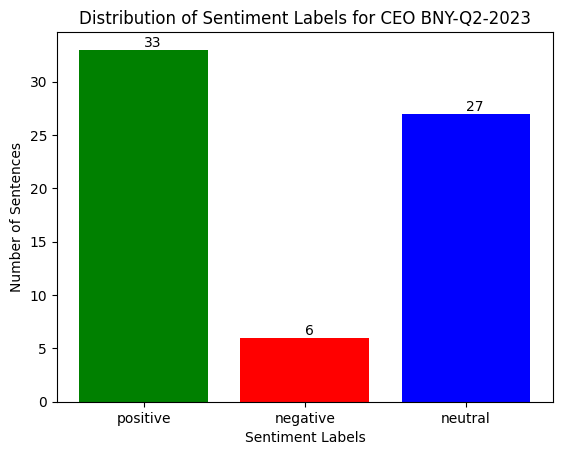

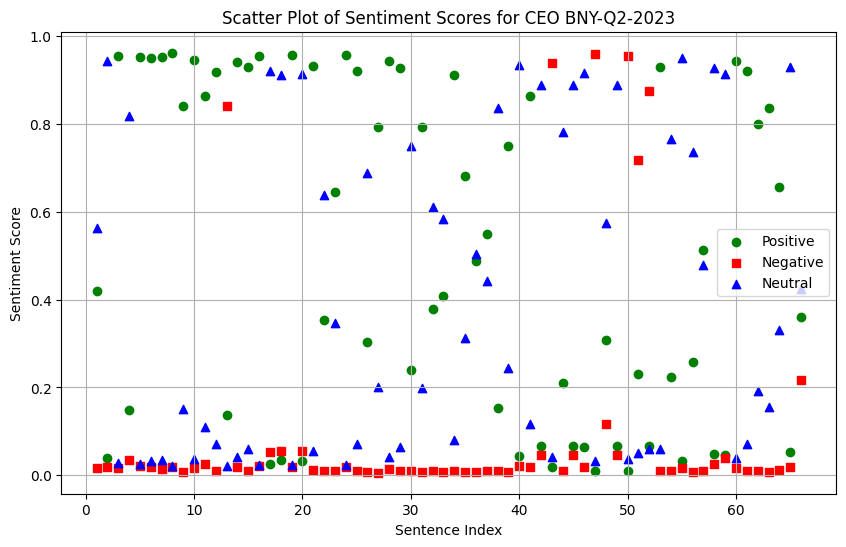

In [35]:
plot_sentiment_labels(ceo_labels, plot_label='CEO BNY-Q2-2023')
plot_sentiment_scores(ceo_scores, ceo_labels, plot_label='CEO BNY-Q2-2023')

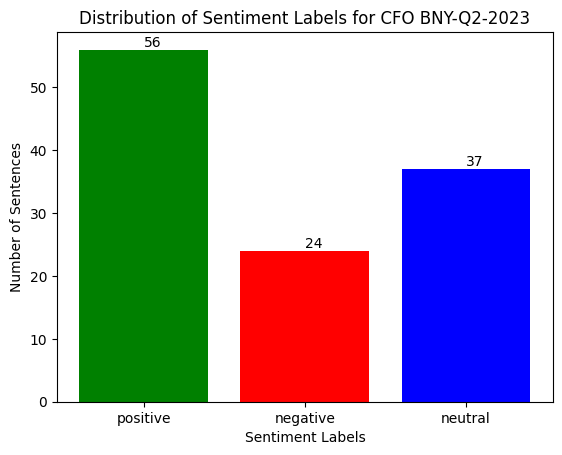

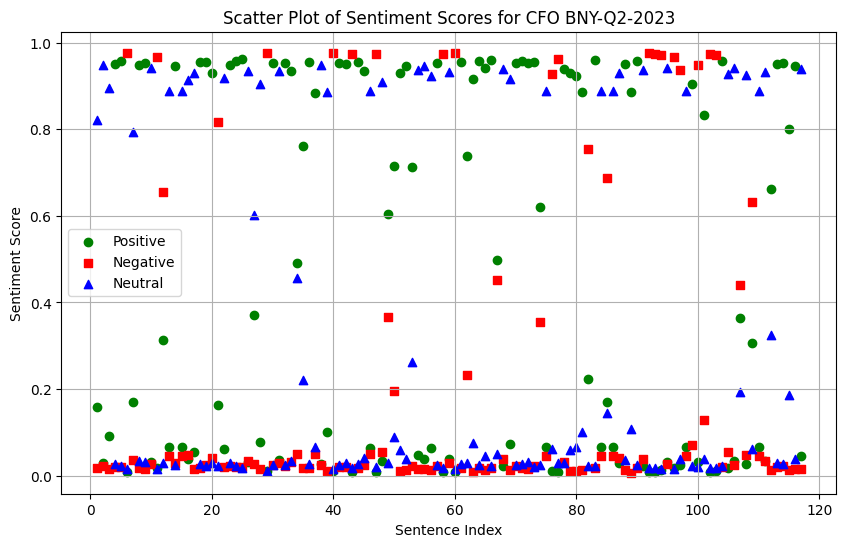

In [33]:
plot_sentiment_labels(cfo_labels, plot_label='CFO BNY-Q2-2023')
plot_sentiment_scores(cfo_scores, cfo_labels, plot_label='CFO BNY-Q2-2023')

# (2) Q&A SECTION (need to edit...)
## Get questions or answers

In [34]:
QUESTION_FILE_PATH = "csv/bny_q2_2023_questions.csv"
ANSWER_FILE_PATH = "csv/ntrs_q1_2020_answers.csv"

In [5]:
def get_qa_list(qa_csv):
  qa_df = pd.read_csv(qa_csv)
  qa_array = np.array(qa_df)
  qa_list = list(qa_array[:,4])

  return qa_list

## Get model and tokenizer

In [19]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

## Inference on the question text with the FinBERT model implemented in HuggingFace

In [7]:
def chunk_list(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def inference(qa_list, qa_type):
  """
  Inference on the text with the FinBERT model implemented in HuggingFace.
  """
  text = None
  if qa_type.lower() == "question":
    text = "Question"
  elif qa_type.lower() == "answer":
    text = "Answer"

  STRIDE = 1 # increase based on data size
  model.eval()

  n=0
  sentiment_df = pd.DataFrame(columns=[text, "Positive", "Negative", "Neutral"])

  for qa in chunk_list(qa_list, STRIDE):

    input = tokenizer(qa, padding = True, truncation = True,  return_tensors='pt')
    outputs = model(**input)
    prediction = torch.nn.functional.softmax(outputs.logits, dim=-1)
    print(f"{n+1}/{int(len(qa_list)/STRIDE)}")

    for q_or_a, pos, neg, neutr in zip(qa, prediction[:, 0].tolist(), prediction[:, 1].tolist(), prediction[:, 2].tolist() ):
      new_row = {text: q_or_a, "Positive": pos, "Negative": neg, "Neutral": neutr}
      sentiment_df = pd.concat([sentiment_df, pd.DataFrame([new_row])], ignore_index=True)
      
    n+=1

  return sentiment_df

## Merge sentiment results to QA datasets

In [8]:
def get_sentiment(row):
  """
  Assigns sentiment label based on the maximum score.
  """
  max_score = max(row["Positive"], row["Negative"], row["Neutral"])
  if max_score == row["Positive"]:
    return "Positive"
  elif max_score == row["Negative"]:
    return "Negative"
  else:
    return "Neutral"

def get_sentiment_df(qa_type):
  qa_list, qa_df, merge_df_on = None, None, None

  # load data
  if qa_type.lower() == "question":
    qa_list = get_qa_list(QUESTION_FILE_PATH)
    qa_df = pd.read_csv(QUESTION_FILE_PATH)
    merge_df_on = "Question"
  elif qa_type.lower() == "answer":
    qa_list = get_qa_list(ANSWER_FILE_PATH)
    qa_df = pd.read_csv(ANSWER_FILE_PATH)
    merge_df_on = "Answer"

  # inference
  sentiment_df = inference(qa_list, qa_type)
  # display(sentiment_df.head())

  # get max sentiment score
  sentiment_df["Sentiment"] = sentiment_df.apply(get_sentiment, axis=1)
  # display(sentiment_df.head())

  # merge with original
  sentiment_df = pd.merge(qa_df, sentiment_df, on=merge_df_on, how='inner')
  # display(sentiment_df.head())

  return sentiment_df

In [9]:
q_sentiment_df = get_sentiment_df("Question")
display(q_sentiment_df.head())

1/11
2/11
3/11
4/11
5/11
6/11
7/11
8/11
9/11
10/11
11/11


,Question ID,Speaker ID,Speaker Company,Speaker Name,Question,Positive,Negative,Neutral,Sentiment
0,0,5,"UBS Investment Bank, Research Division",Brennan Hawken,"Dermot, I'd like to start with which you just ...",0.321803,0.114613,0.563584,Neutral
1,1,3,"Goldman Sachs Group, Inc., Research Division",Alexander Blostein,Just a quick follow-up first maybe around the ...,0.082128,0.029360,0.888512,Neutral
2,2,4,"Morgan Stanley, Research Division",Betsy Lynn Graseck,"I know we talked a lot about deposits, but I d...",0.045536,0.058567,0.895897,Neutral
3,3,13,"Wolfe Research, LLC",Steven Joseph Chubak,So wanted to dig into noninterest-bearing depo...,0.243692,0.018269,0.738039,Neutral
4,4,9,"Evercore ISI Institutional Equities, Research ...",Glenn Paul Schorr,So the FedNow platform has started for interba...,0.060481,0.065099,0.874420,Neutral


In [10]:
a_sentiment_df = get_sentiment_df("Answer")
display(a_sentiment_df.head())

1/24
2/24
3/24
4/24
5/24
6/24
7/24
8/24
9/24
10/24
11/24
12/24
13/24
14/24
15/24
16/24
17/24
18/24
19/24
20/24
21/24
22/24
23/24
24/24


,Answer ID,Speaker ID,Speaker Company,Speaker Name,Answer,Positive,Negative,Neutral,Sentiment
0,0,0,CFO & Executive VP,Jason Jerrome Tyler,"Sure. Alex, let me -- I'll start on the first ...",0.210292,0.021790,0.767918,Neutral
1,0,2,"Chairman, President & CEO",Michael G. O’Grady,"Yes, this is Mike. I would just add to what Ja...",0.189048,0.218728,0.592224,Neutral
2,1,0,CFO & Executive VP,Jason Jerrome Tyler,"Sure, Glenn. Well, let me just start with some...",0.055259,0.077723,0.867017,Neutral
3,1,1,Senior VP & Director of Investor Relations,Mark M. Bette,"Yes. Looking at the entire loan portfolio, ove...",0.049549,0.026874,0.923577,Neutral
4,2,0,CFO & Executive VP,Jason Jerrome Tyler,"Sure. Thanks, Mike. I'll start. Well, first of...",0.057368,0.097863,0.844769,Neutral


## Visualizing sentiment differences

In [11]:
def visualize_sentiment(sentiment_df, qa_type, file_name):
  positive = sentiment_df["Positive"]
  negative = sentiment_df["Negative"]
  neutral = sentiment_df["Neutral"]
  idx = range(1, len(sentiment_df) + 1)  # Create index numbers (1-based)

  # Plotting the variations
  plt.figure(figsize=(10, 6))  # Adjust figure size as needed
  plt.plot(idx, positive, label="Positive", marker='o', color='green')
  plt.plot(idx, negative, label="Negative", marker='s', color='red')
  plt.plot(idx, neutral, label="Neutral", marker='^', color='blue')

  # Adding labels and title
  plt.xlabel(f"{qa_type} Number")
  plt.ylabel("Sentiment Score")
  plt.title(f"Variations in {qa_type} Sentiment Score ({file_name})")

  # Adding legend
  plt.legend()

  # Grid and rotation
  plt.grid(True)

  # Show the plot
  plt.tight_layout()
  plt.show()


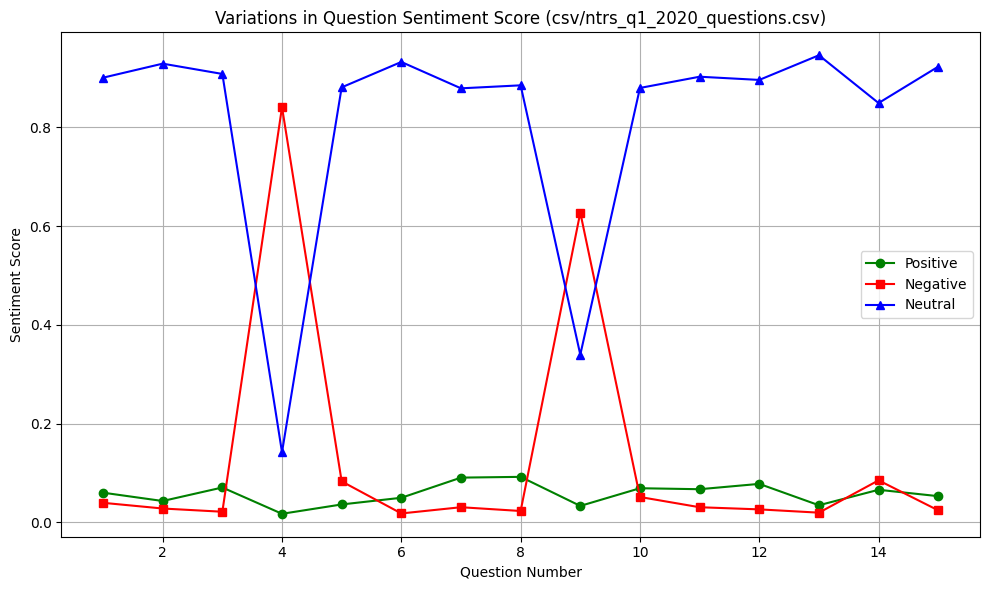

In [12]:
visualize_sentiment(q_sentiment_df, qa_type="Question", file_name=QUESTION_FILE_PATH)

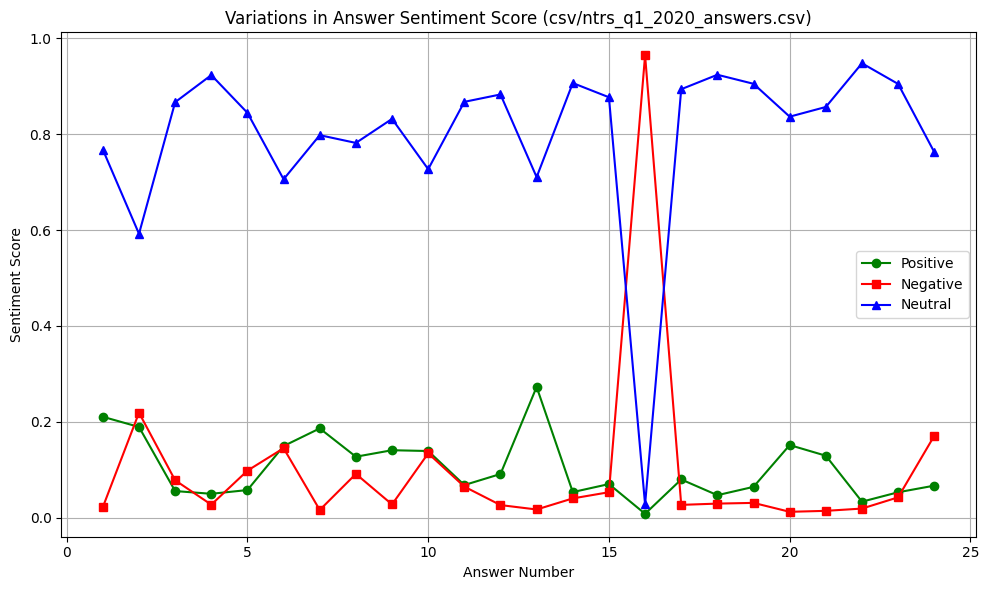

In [13]:
visualize_sentiment(a_sentiment_df, qa_type="Answer", file_name=ANSWER_FILE_PATH)